

Seaview Survey Photo-quadrat and Image Classification Dataset 

#### Data provider
The data is provided by the _XL Catlin Seaview Survey Project_ that was developped as a collaboration between the University of Queensland and ocean conservaton non-profit Underwater Earth.


The goal of their project is to collect rapid, detailed, globally distributed scientific surveys of coral reefs to support research and conservation.
The data colletion took part between 2012-2018 with a custom camera that produced high quality photographs of the reef at transect that were usually 1.5-2 km long. Images were taken between 0.5-2m to ensure constistent spatial resolution (around 10 pixels/cm).


#### Data specifics
The raw data is a collection of over one million images covering around 1m² of the sea floor. You also have human-classified annotations that may be used to train and validate image classifiers.
Deep learning algorithms (VGG-D 16 network architecture) were used to estimate the benthic cover from each photo. The relative abundance of each benthic group was also estimated by using deep learning algorithms.

For this project we are interested in the benthic cover of the corals derived from the images and we will thus not focus on the images. 

#### Data sets used
The "seaviewsurvey_surveys.csv", contains **the proportional cover of reef cover** between _hard_ or _soft_ corals, _other invertebrates_ or _other_ or algea. 
It also has "lat_start, lng_start", the latitude and longitude of start of survey but also the end "lat_end, lng_end". 

The "seaviewsurvey_reefcover_Australia.csv" contains summary classification data for each photo, represented as **a percent cover**. Here we get the proportional cover of the specified class name within the photo-quadrat. It is thus more specific than the previous one. The file also contains the latitude and longitude of the photo quadrat for easy spotage. The survey id is also given which we can then link with the other data sets. 





### To do 

Questions I am asking myself
- how many surveys per year ok
- distirbution in space ok
- hwo close are they ? 
- Do you have several points in one square (transect id) ok
- How does the distribution change ok
- Size of transect id 

In [1]:
# Import useful packages

import gdal
import pandas as pd
import geopandas as gpd
from io import StringIO
import osr
import matplotlib.pyplot as plt
import pandas as pd
import rtree
import pygeos
import os, json
import geopandas as gpd
from ipywidgets import widgets
from ipyleaflet import Map, GeoData, basemaps, LayersControl, ScaleControl, FullScreenControl, WidgetControl
from ipywidgets import widgets, IntSlider, jslink
import numpy as np

import sys
sys.path.insert(0, os.path.abspath(''))

import practical_functions as pf


import seaborn as sns
#bokeh
sns.set_theme(style="whitegrid")
import warnings
warnings.filterwarnings("ignore")

# Load image from local storage
from IPython.display import Image

from ipyleaflet import *

/home/lavinia/.local/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
# Import the csv data with percentage of hard, soft corals, other inverterbrates and other things 
Survey = pd.read_csv("../Data/Reefs/seaviewsurvey_surveys.csv")
Survey.head()

,surveyid,transectid,surveydate,ocean,country,folder_name,lat_start,lng_start,lat_end,lng_end,pr_hard_coral,pr_algae,pr_soft_coral,pr_oth_invert,pr_other
0,10001,10001,20120916,PAC,AUS,PAC_AUS_10001_201209,-16.189023,145.898104,-16.191761,145.894088,0.1856,0.3724,0.2710,0.0010,0.1700
1,10002,10002,20120917,PAC,AUS,PAC_AUS_10002_201209,-16.189303,145.898254,-16.175947,145.889736,0.1364,0.4766,0.3079,0.0020,0.0771
2,10003,10003,20120918,PAC,AUS,PAC_AUS_10003_201209,-16.175768,145.891676,-16.181218,145.888904,0.2475,0.5653,0.0747,0.0207,0.0917
3,10004,10004,20120920,PAC,AUS,PAC_AUS_10004_201209,-16.536645,147.806796,-16.524287,147.843325,0.1242,0.5706,0.0279,0.0023,0.2748
4,10005,10005,20120920,PAC,AUS,PAC_AUS_10005_201209,-16.529216,147.802582,-16.521689,147.836180,0.0781,0.7894,0.0096,0.0029,0.1201


In [3]:
# 860 total surveys 
Survey.shape

(860, 15)

In [4]:
# Keep only Australia as country 
Survey_AUS = Survey[Survey["country"] == "AUS"]
# Make the integers "surveydate" as a real time frame 
Survey_AUS['surveydate'] = pd.to_datetime(Survey_AUS['surveydate'], format='%Y%m%d')
Survey_AUS.head()

,surveyid,transectid,surveydate,ocean,country,folder_name,lat_start,lng_start,lat_end,lng_end,pr_hard_coral,pr_algae,pr_soft_coral,pr_oth_invert,pr_other
0,10001,10001,2012-09-16,PAC,AUS,PAC_AUS_10001_201209,-16.189023,145.898104,-16.191761,145.894088,0.1856,0.3724,0.2710,0.0010,0.1700
1,10002,10002,2012-09-17,PAC,AUS,PAC_AUS_10002_201209,-16.189303,145.898254,-16.175947,145.889736,0.1364,0.4766,0.3079,0.0020,0.0771
2,10003,10003,2012-09-18,PAC,AUS,PAC_AUS_10003_201209,-16.175768,145.891676,-16.181218,145.888904,0.2475,0.5653,0.0747,0.0207,0.0917
3,10004,10004,2012-09-20,PAC,AUS,PAC_AUS_10004_201209,-16.536645,147.806796,-16.524287,147.843325,0.1242,0.5706,0.0279,0.0023,0.2748
4,10005,10005,2012-09-20,PAC,AUS,PAC_AUS_10005_201209,-16.529216,147.802582,-16.521689,147.836180,0.0781,0.7894,0.0096,0.0029,0.1201


In [5]:
Survey_AUS.shape

(261, 15)

In [6]:
# Import the more precise benthic cover data
Benthic = pd.read_csv("../Data/Reefs/seaviewsurvey_reefcover_pacificaustralia.csv")
Benthic.head()

,surveyid,imageid,quadratid,lat,lng,ACR-BRA,ACR-HIP,ACR-OTH,ACR-PE,ACR-TCD,...,OTH-SF,OTH-SINV,POCI,POR-BRA,POR-ENC,POR-MASS,Sand,Turf,Turfsa,Unc
0,10001,100010007,10001000701,-16.189056,145.898116,0.0,0.0,0.0,0.0,0.02,...,0.72,0.00,0.02,0.0,0.02,0.00,0.00,0.0,0.0,0.02
1,10001,100010007,10001000702,-16.189056,145.898116,0.0,0.0,0.0,0.0,0.06,...,0.68,0.04,0.02,0.0,0.12,0.00,0.02,0.0,0.0,0.02
2,10001,100010008,10001000801,-16.189075,145.898118,0.0,0.0,0.0,0.0,0.22,...,0.64,0.00,0.02,0.0,0.00,0.00,0.00,0.0,0.0,0.00
3,10001,100010008,10001000802,-16.189075,145.898118,0.0,0.0,0.0,0.0,0.02,...,0.60,0.00,0.00,0.0,0.10,0.02,0.00,0.0,0.0,0.00
4,10001,100010008,10001000803,-16.189075,145.898118,0.0,0.0,0.0,0.0,0.00,...,0.72,0.00,0.00,0.0,0.12,0.00,0.12,0.0,0.0,0.00


<AxesSubplot:>

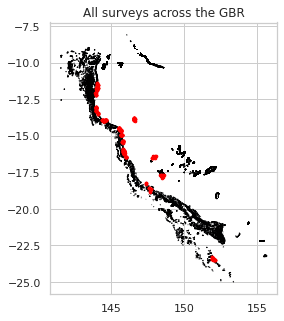

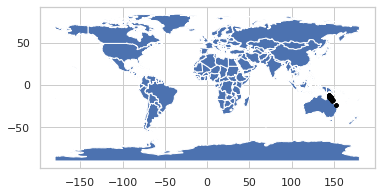

In [7]:
# Map of the world
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
Survey_AUS_end = Survey_AUS.copy()
# Data frame with start survey coordinates as geometric points 
gSurvey = gpd.GeoDataFrame(Survey_AUS, geometry = gpd.points_from_xy(Survey_AUS.lng_start, Survey_AUS.lat_start))

gSurvey_end = gpd.GeoDataFrame(Survey_AUS_end, geometry = gpd.points_from_xy(Survey_AUS.lng_end, Survey_AUS.lat_end))

# Map of GBR
shx = gpd.read_file("../Data/GBR_shapes_surveys/Reefs_GBR.shx")
ax = shx.plot(figsize=(15, 5), edgecolor='black')
ax.set_title("All surveys across the GBR")

# Plot the survey points on the GBR map
gSurvey.plot(ax = ax, color = 'red',markersize=7)

# Plot the survey points on the world map
ax_world = world.plot()
gSurvey.plot(ax = ax_world, color = 'black',markersize=7)

In [8]:
# Take the mean of the percentage cover for the whole dataframe 

mean_hard_coral = pf.mean_col(Survey_AUS, "pr_hard_coral")
mean_soft_coral = pf.mean_col(Survey_AUS, "pr_soft_coral")
mean_algae_coral = pf.mean_col(Survey_AUS, "pr_algae")
mean_oth_inv_coral = pf.mean_col(Survey_AUS, "pr_oth_invert")
mean_oth_coral = pf.mean_col(Survey_AUS, "pr_other")
mean_spec = pd.DataFrame({'Mean': [mean_hard_coral, mean_soft_coral, mean_algae_coral, mean_oth_inv_coral, mean_oth_coral]},index=["pr_hard_coral", "pr_soft_coral","pr_algae", "pr_oth_invert", "pr_other"])

###### Plot the means as pie plot 

<AxesSubplot:ylabel='Mean'>

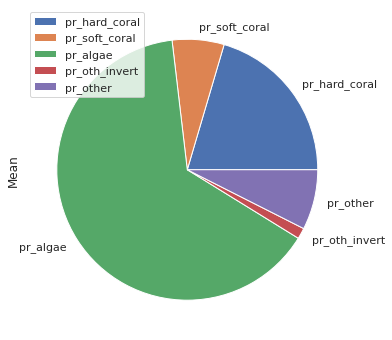

In [9]:
mean_spec.plot.pie(y = "Mean", figsize=(11, 6))

###### Number of surveys per year

In [10]:
Survey_AUS["surveydate"].dt.year.value_counts().reset_index()

,index,surveydate
0,2012,118
1,2016,60
2,2014,48
3,2017,35


We note that the number of surveys in 2012 were the highest, that is, the first year in which they conducted the study. 

In [11]:
# Split the data frames based on the years
Survey_2012, Survey_2014, Survey_2016, Survey_2017 = pf.split_years(Survey_AUS)
Survey_2012_end, Survey_2014_end, Survey_2016_end, Survey_2017_end = pf.split_years(Survey_AUS_end)

###### Make a Geodata-frame with the survey points

In [12]:
gSurvey_2012 = pf.make_geo_frame(Survey_2012)
gSurvey_2014 = pf.make_geo_frame(Survey_2014)
gSurvey_2016 = pf.make_geo_frame(Survey_2016)
gSurvey_2017 = pf.make_geo_frame(Survey_2017)

gSurvey_2012_end = pf.make_geo_frame(Survey_2012_end)
gSurvey_2014_end = pf.make_geo_frame(Survey_2014_end)
gSurvey_2016_end = pf.make_geo_frame(Survey_2016_end)
gSurvey_2017_end = pf.make_geo_frame(Survey_2017_end)

###### Export the different surveys per year// visualized in QGIS

In [13]:
pf.export_shape(gSurvey_2012.drop(columns= "surveydate"), "../Data/GBR_shapes_surveys/survey_2012")
pf.export_shape(gSurvey_2014.drop(columns= "surveydate"), "../Data/GBR_shapes_surveys/survey_2014")
pf.export_shape(gSurvey_2016.drop(columns= "surveydate"), "../Data/GBR_shapes_surveys/survey_2016")
pf.export_shape(gSurvey_2017.drop(columns= "surveydate"), "../Data/GBR_shapes_surveys/survey_2017")


pf.export_shape(gSurvey_2012_end.drop(columns= "surveydate"), "../Data/GBR_shapes_surveys/survey_2012_end")
pf.export_shape(gSurvey_2014_end.drop(columns= "surveydate"), "../Data/GBR_shapes_surveys/survey_2014_end")
pf.export_shape(gSurvey_2016_end.drop(columns= "surveydate"), "../Data/GBR_shapes_surveys/survey_2016_end")
pf.export_shape(gSurvey_2017_end.drop(columns= "surveydate"), "../Data/GBR_shapes_surveys/survey_2017_end")

###### Import the visualized files from QGIS

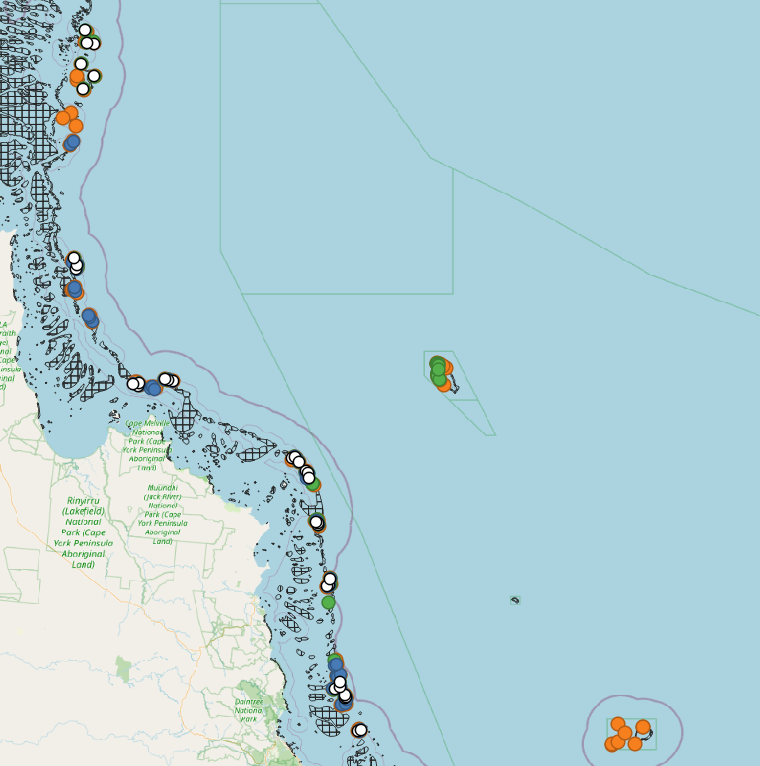

In [14]:
Image(filename = "../Data/Photos/map_surveys.png", width = 600, height = 300)

- Orange = 2012
- Green = 2014
- Blue = 2016
- White = 2017


###### Verify if one year has several surveys within the same transectid
Might need to take the average of it 

In [15]:
# Look if any transectid (square) has several surveys in it 
print("Survey_2012: = ",pf.trans_surv(gSurvey_2012)[0])
print("Survey_2014: = ",pf.trans_surv(gSurvey_2014)[0])
print("Survey_2016: = ",pf.trans_surv(gSurvey_2016)[0])
print("Survey_2017: = ",pf.trans_surv(gSurvey_2017)[0])

pf.trans_surv(gSurvey_2014)[1]

Survey_2012: =  0
Survey_2014: =  1
Survey_2016: =  0
Survey_2017: =  0


,surveyid,transectid,surveydate,ocean,country,folder_name,lat_start,lng_start,lat_end,lng_end,pr_hard_coral,pr_algae,pr_soft_coral,pr_oth_invert,pr_other,geometry,year
325,27002,12029,2014-05-09,PAC,AUS,PAC_AUS_27002_201405,-14.663358,145.664066,-14.663371,145.664061,0.1115,0.8079,0.0355,0.0228,0.0225,POINT (145.66407 -14.66336),2014
326,27003,12029,2014-05-09,PAC,AUS,PAC_AUS_27003_201405,-14.663525,145.663656,-14.663355,145.663741,0.0992,0.8270,0.0411,0.0129,0.0197,POINT (145.66366 -14.66352),2014


We see that only one survey from 2014 was taken in the same transectid, the rest are all independent 

In [16]:
# Let us look at the intersections between the different surveys
df_2012 = pf.smart_df(gSurvey_2012, 2012)
df_2014 = pf.smart_df(gSurvey_2014, 2014)
df_2016 = pf.smart_df(gSurvey_2016, 2016)
df_2017 = pf.smart_df(gSurvey_2017, 2017)

In [17]:
# Outer join all data sets
df_joined = df_2012.join(df_2014, how = "outer").join(df_2016, how = "outer").join(df_2017, how = "outer")
# Fill the NaN values with "False"
df_joined.fillna(False, inplace = True)
# Sum on the trasectid (if 4 then all years have surveyed at this place)
df_joined["Sum"] = df_joined.sum(axis = 1)
df_joined.head()

,2012,2014,2016,2017,Sum
transectid,,,,,
10001,True,True,True,True,4
10002,True,True,True,True,4
10003,True,False,True,True,3
10004,True,False,False,False,1
10005,True,False,False,False,1


Text(0.5, 0, 'Occurences at same transect ID')

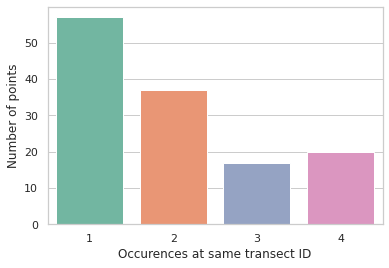

In [18]:
# plot occurences
ax = sns.countplot(x="Sum", data=df_joined, palette="Set2")
ax.set_ylabel('Number of points')
ax.set_xlabel('Occurences at same transect ID')

Text(0.5, 0, 'Occurences')

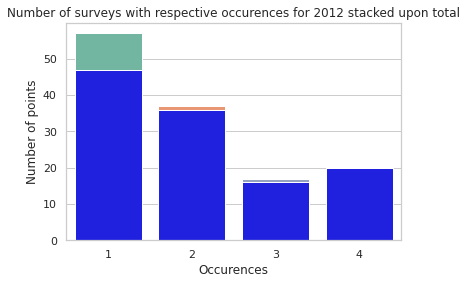

In [19]:
ax = sns.countplot(x="Sum", data=df_joined, palette="Set2")
ax.set_ylabel('Number of points')
ax.set_xlabel('Occurences at same transect ID')
# Let us replace the Boolean by the number of surveys which share a survey in the georaphic location
df_bool = df_joined.copy()
for i in range(4):
    df_joined.iloc[:,i] = df_joined.iloc[:,i]*df_joined['Sum']
df_joined_no_sum = df_joined.drop(columns = "Sum")   


ax = sns.countplot(x = 2012, data=df_joined_no_sum[-(df_joined_no_sum[2012] == 0)], color = "blue")
ax.set_title('Number of surveys with respective occurences for 2012 stacked upon total')
ax.set_ylabel('Number of points')
ax.set_xlabel('Occurences')

We note that only around:
- 20 points were taken at the 4 different years // (equivalent to 80 surveys)
- 17 at 3 years
- 35 at 2 years
- 55 only once --> This is bad news, but we know the 2012 had many more surveys than the other years so let us try and see how the years are distributed with occurences 


In black, it's the surveys from 2012, as we may see and unsurpinsgly so. It takes up most of the 1 and 2nd independent places. this is good news.


## Distribution of "species" with the years

In [20]:
# Here I am taking the mean of the surveys, this was to check the mean per year, but be aware
# that I did not take into account spatial 
Survey_mean = Survey_AUS.groupby(["year"], as_index = False).mean()
Survey_mean

,year,surveyid,transectid,lat_start,lng_start,lat_end,lng_end,pr_hard_coral,pr_algae,pr_soft_coral,pr_oth_invert,pr_other
0,2012,12743.610169,12743.610169,-15.343183,146.132773,-15.342325,146.129333,0.220435,0.589255,0.074544,0.012550,0.103204
1,2014,32888.583333,14995.520833,-14.618066,145.743920,-14.617398,145.742180,0.219944,0.662515,0.058858,0.012617,0.046056
2,2016,44289.000000,16833.133333,-16.285364,146.371320,-16.283135,146.371235,0.188382,0.683850,0.052745,0.015107,0.059905
3,2017,47018.000000,13418.000000,-14.301355,145.098854,-14.298800,145.098036,0.156740,0.729780,0.056637,0.015174,0.041597


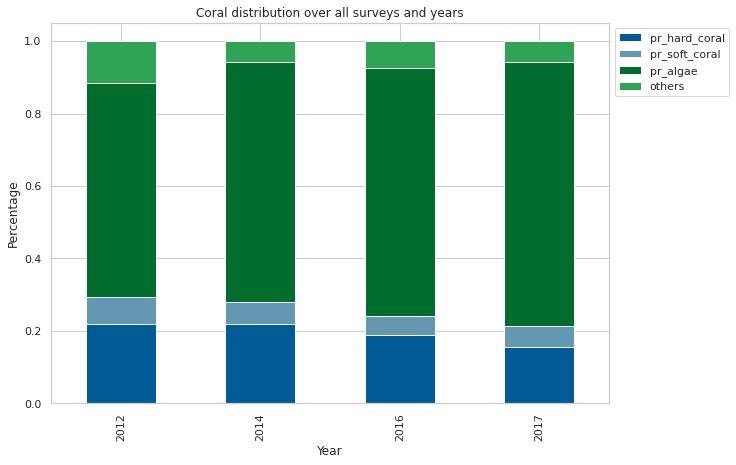

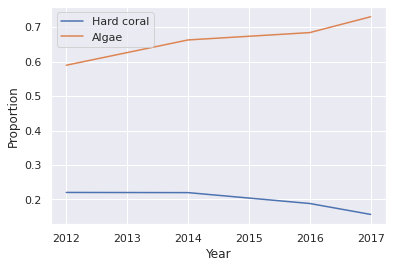

In [21]:
# Plot for mean 
pf.plot_mean_stack(Survey_mean, "Coral distribution over all surveys and years")
pf.hard_algae_plot(Survey_mean)

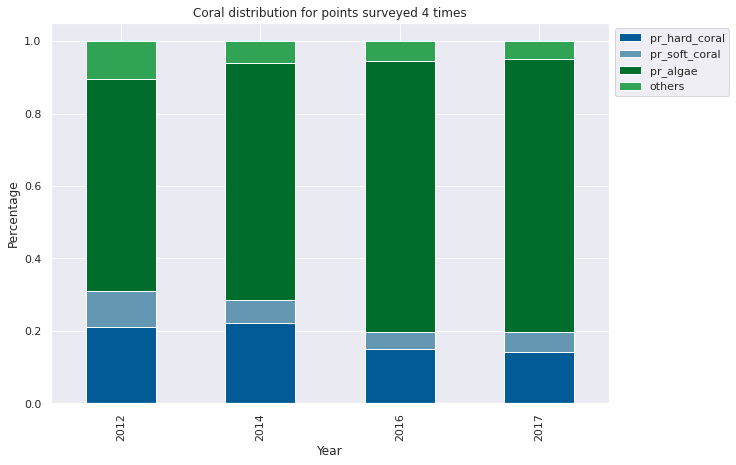

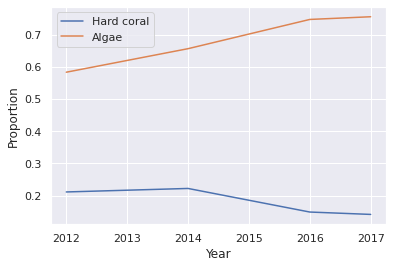

In [22]:
# This is the means for the regions that are the same 
df_4_region = pf.mean_region(Survey_AUS, df_joined, 4)
df_4 = df_4_region.groupby("year").mean()
pf.plot_mean_stack(df_4.reset_index(), "Coral distribution for points surveyed 4 times")
pf.hard_algae_plot(df_4)

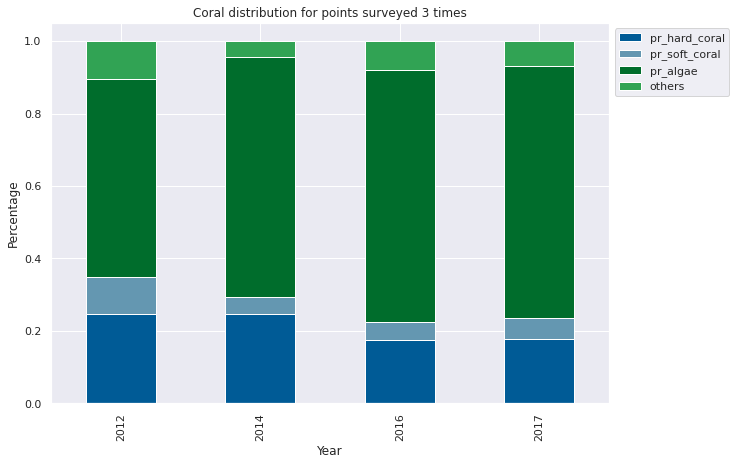

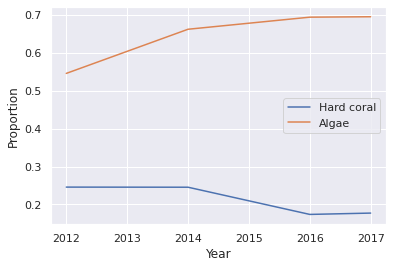

In [23]:
# This is the means for the regions that are the same 
df_3_region = pf.mean_region(Survey_AUS, df_joined, 3)
df_3 = df_3_region.groupby("year").mean()
pf.plot_mean_stack(df_3.reset_index(), "Coral distribution for points surveyed 3 times")
pf.hard_algae_plot(df_3)

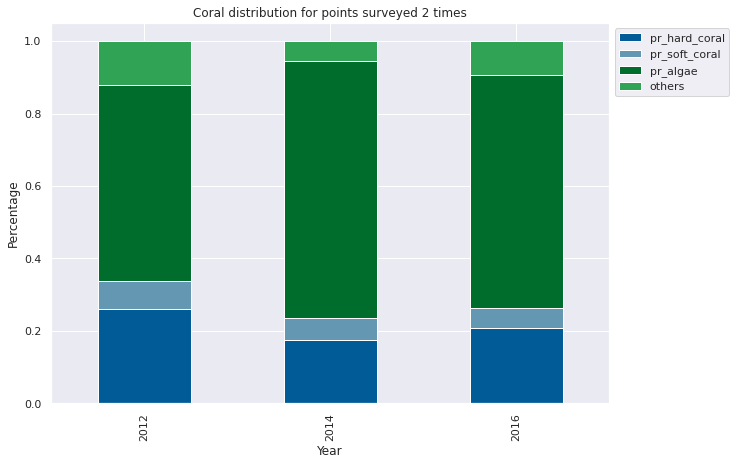

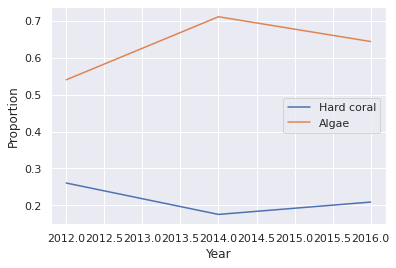

In [24]:
# This is the means for the regions that are the same 
df_2_region = pf.mean_region(Survey_AUS, df_joined, 2)
df_2 = df_2_region.groupby("year").mean()
pf.plot_mean_stack(df_2.reset_index(), "Coral distribution for points surveyed 2 times")
pf.hard_algae_plot(df_2.reset_index())

#### More insighful
It might be more insightful to look at the distribution of corals but within similar regions 



In [25]:
df_4_region = pf.make_geo_frame(df_4_region)
df_3_region = pf.make_geo_frame(df_3_region)


### Where are the corals 



<AxesSubplot:title={'center':'Continous survey locationsfor 4 years'}>

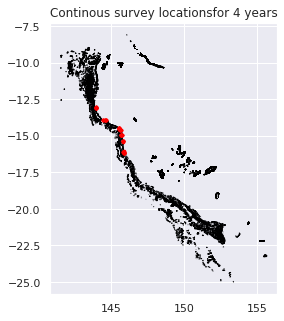

In [26]:
shx = gpd.read_file("../Data/GBR_shapes_surveys/Reefs_GBR.shx")
ax = shx.plot(figsize=(15, 5), edgecolor='black')
ax.set_title("Continous survey locationsfor 4 years")

# Plot the survey points on the GBR map
#gSurvey_2012.plot("pr_algea", ax = ax,color = "blue",markersize=7)
df_4_region.plot("pr_hard_coral", ax = ax,color = "red",markersize=7)


<AxesSubplot:title={'center':'Continous survey locations for 3 years'}>

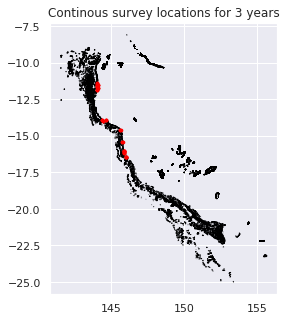

In [27]:
shx = gpd.read_file("../Data/GBR_shapes_surveys/Reefs_GBR.shx")
ax = shx.plot(figsize=(15, 5), edgecolor='black')
ax.set_title("Continous survey locations for 3 years")

df_3_region.plot("pr_hard_coral", ax = ax,color = "red",markersize=7)

df_joined## Difference between 2012 and 2017 
Now I am interested in how the proportions changed for surveys located in the same point for 2012 and 2017 

In [28]:
# retrieve transect id where you have surveys and for 2012 and for 2017
list_12_17 = df_bool.index[(df_bool[2012] == True) & (df_bool[2017] == True)].tolist()
print("You have ",len(list_12_17), " points where one survey was done in 2012 and another in 2017")

You have  34  points where one survey was done in 2012 and another in 2017


In [29]:
df_12 = pf.fun(gSurvey_2012,list_12_17)
df_17 = pf.fun(gSurvey_2017,list_12_17)

In [30]:
# Add the difference of hard coral and algae between 2017 qnd 2012 to dataframe 
# Add zero line
pf.group_others(df_17)
pf.group_others(df_12)

# Add others 
df_17["diff_hard"] = df_17["pr_hard_coral"] - df_12["pr_hard_coral"]
df_17["diff_algae"] = df_17["pr_algae"] - df_12["pr_algae"]
df_17["diff_others"] = df_17["others"] - df_12["others"]

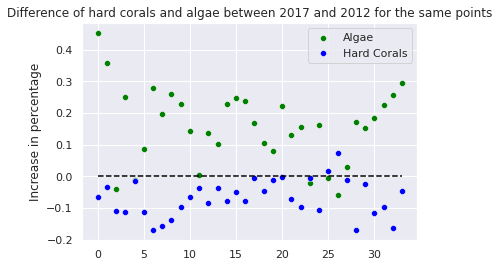

In [31]:
sns.scatterplot(y = df_17["diff_algae"], x = range(34),color="Green", label = "Algae")

ax = sns.scatterplot(y = df_17["diff_hard"], x = range(34), color = "Blue", label = "Hard Corals")
#ax = sns.scatterplot(y = df_17["diff_others"], x = range(34), color = "Red", label = "Others")
ax.set( xlabel = "", ylabel='Increase in percentage')
ax.set_title("Difference of hard corals and algae between 2017 and 2012 for the same points")
plt.plot(range(34), np.zeros(34),'--', color = "black")
plt.show()



## Spatial distribution of differences 
Next Goal: look at spatial distribution of regions depending on their difference of hard corals between 2012 and 2017, to note if some regions are more prone to decay than others



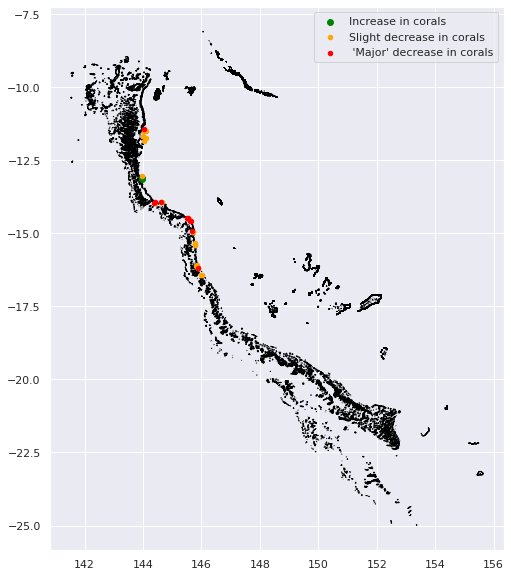

In [32]:
shx = gpd.read_file("../Data/GBR_shapes_surveys/Reefs_GBR.shx")
ax = shx.plot(figsize=(20, 10), edgecolor='black')

df_cor_increase = df_17[df_17["diff_hard"] >= 0]
df_cor_increase.plot(ax = ax, color = "green", markersize = 35, label = "Increase in corals")

df_minor_decrease = df_17[(df_17["diff_hard"] < 0) & (df_17["diff_hard"] > -0.1)]
df_minor_decrease.plot(ax =ax, color = "orange", markersize = 20, label = "Slight decrease in corals")

df_major_decrease = df_17[(df_17["diff_hard"] <= -0.1)]
df_major_decrease.plot(ax = ax, color = "red", markersize = 20, label = " 'Major' decrease in corals")


ax.legend();

In [33]:
df_lat = df_17.copy()
if ('lat'not in df_lat.columns):
    df_lat["lat"] = df_17["geometry"].y
    
df_lat["increase"] = df_lat["diff_hard"] >= 0
df_lat["slight_decrease"] = (df_17["diff_hard"] < 0) & (df_17["diff_hard"] > -0.1)
df_lat["major_decrease"] = (df_17["diff_hard"] <= -0.1)
df_lat.head()

,pr_hard_coral,pr_soft_coral,pr_algae,pr_oth_invert,pr_other,geometry,year,others,diff_hard,diff_algae,diff_others,lat,increase,slight_decrease,major_decrease
transectid,,,,,,,,,,,,,,,
10001,0.1192,0.0437,0.8253,0.0081,0.0037,POINT (145.89493 -16.19389),2017,0.0555,-0.0664,0.4529,-0.3865,-16.193885,False,True,False
10002,0.1038,0.0380,0.8329,0.0073,0.0179,POINT (145.89815 -16.18885),2017,0.0632,-0.0326,0.3563,-0.3238,-16.188854,False,True,False
10003,0.1385,0.0324,0.5264,0.0058,0.2968,POINT (145.89116 -16.17526),2017,0.3350,-0.1090,-0.0389,0.1479,-16.175264,False,False,True
12005,0.0591,0.0187,0.7207,0.0067,0.1945,POINT (145.61609 -14.57076),2017,0.2199,-0.1126,0.2504,-0.1380,-14.570760,False,False,True
12025,0.1717,0.0535,0.7665,0.0079,0.0001,POINT (145.56221 -14.50807),2017,0.0615,-0.0144,-0.0126,0.0267,-14.508070,False,True,False


Text(0.5, 1.0, 'Change in corals between 2017-2012 based on latitude')

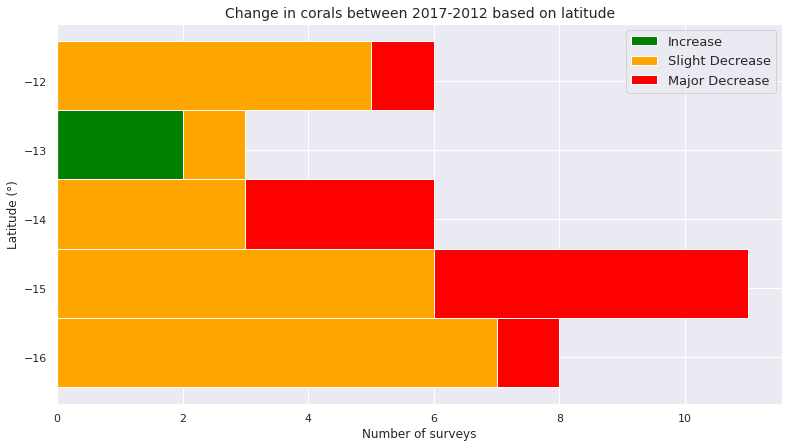

In [34]:

fig = plt.figure(figsize = (13,7))

h1 = fig.add_subplot()

bins = 5

h1.hist([df_lat[df_lat["increase"]]["lat"],df_lat[df_lat["slight_decrease"]]["lat"],df_lat[df_lat["major_decrease"]]["lat"]], bins=bins, stacked=True, orientation = "horizontal"\
       ,color = ("green", "orange", "red"));
plt.legend(["Increase", "Slight Decrease", "Major Decrease"], fontsize = 13)
plt.ylabel("Latitude (°)")
plt.xlabel("Number of surveys")
plt.title("Change in corals between 2017-2012 based on latitude", fontsize = 14)


(array([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,  12.,  75.,
         190., 152.,  57.,  13.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.],
        [  1.,   1.,   2.,   4.,   9.,  11.,  15.,  26.,  38.,  60., 113.,
         245., 216., 102.,  56.,  27.,  30.,  11.,  13.,   3.,   9.,   3.,
           1.]]),
 array([-60, -55, -50, -45, -40, -35, -30, -25, -20, -15, -10,  -5,   0,
          5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55]),
 <a list of 2 BarContainer objects>)

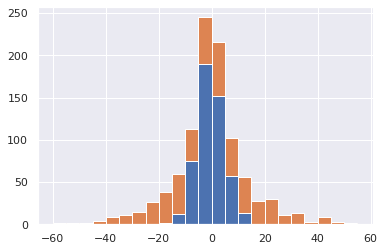

In [35]:

fig = plt.figure()

h1 = fig.add_subplot()


x = np.random.normal(0, 5, 500)
y = np.random.normal(0, 20, 500)

bins = np.arange(-60,60, 5)

h1.hist([x, y], bins=bins, stacked=True)


**Labels**
Below -0.1 (“big” decrease in hard corals): Red dots
Between -0.1 and 0 (“medium decrease in hard corals”): Orange
Above 0 (“increase” in hard corals): Green dots

**Outcome**: We have an area of increase and medium decrease in the center of the zoomed mapped. A medium decrease in the North and some areas of more pronounced decrease in the South. What factors influence this ? → Will hopefully know using the anthropological and environemntal factors

**Next**: Do the same with the algae and then try to see what happens when you group by region instead

### Same with algae

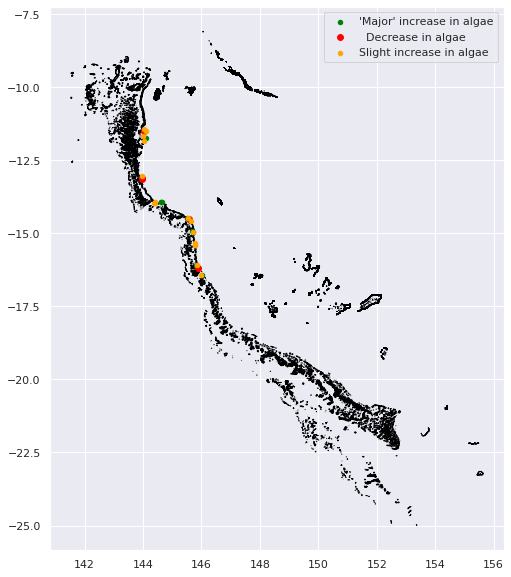

In [36]:
shx = gpd.read_file("../Data/GBR_shapes_surveys/Reefs_GBR.shx")
ax = shx.plot(figsize=(20, 10), edgecolor='black')


df_17[df_17["diff_algae"] >= 0.2].plot(ax = ax, color = "green", markersize = 20, label = "'Major' increase in algae")
df_17[(df_17["diff_algae"] <= 0)].plot(ax = ax, color = "red", markersize = 35, label = "  Decrease in algae")
df_17[(df_17["diff_algae"] > 0) & (df_17["diff_algae"] < 0.2)].plot(ax =ax, color = "orange", markersize = 20, label = "Slight increase in algae")
ax.legend()


In [37]:
df_lat["maj_increase_al"] = df_17["diff_algae"] >= 0.2
df_lat["slight_increase_al"] = (df_17["diff_algae"] > 0) & (df_17["diff_algae"] < 0.2)
df_lat["decrease_al"] = (df_17["diff_algae"] <= 0)

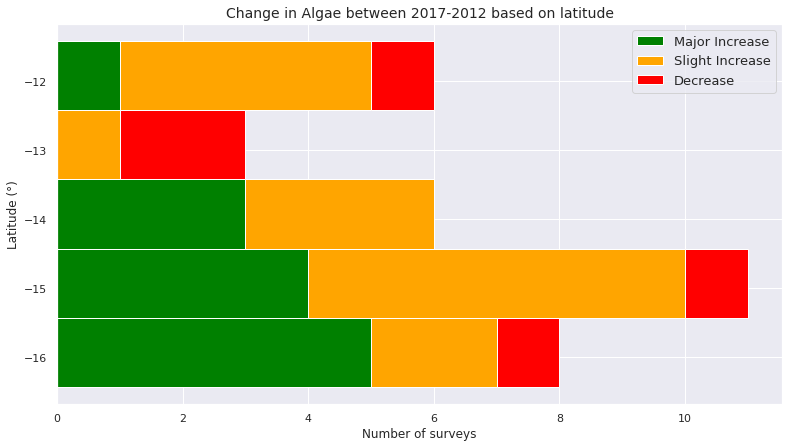

In [38]:
fig = plt.figure(figsize = (13,7))

h1 = fig.add_subplot()

bins = 5

h1.hist([df_lat[df_lat["maj_increase_al"]]["lat"],df_lat[df_lat["slight_increase_al"]]["lat"],df_lat[df_lat["decrease_al"]]["lat"]], bins=bins, stacked=True, orientation = "horizontal"\
       ,color = ("green", "orange", "red"));
plt.legend(["Major Increase", "Slight Increase", "Decrease"], fontsize = 13);
plt.ylabel("Latitude (°)")
plt.xlabel("Number of surveys")
plt.title("Change in Algae between 2017-2012 based on latitude", fontsize = 14);

**Labels**
Above 0.2 (“big” increase in algae): Green dots
Between 0 and 0.2 (“medium increase in algae”): Orange
below 0 (Decrease in algae): Red dots


## Separation between North and South
Looking at the last graph it would be interesting to separate North and South at a latitude of about -13.5°



In [40]:
Survey_geo = pf.make_geo_frame(Survey_AUS)
Survey_geo["lat"] = Survey_geo.geometry.y

Survey_mean_North = Survey_geo[Survey_geo["lat"] >= -13.5].groupby(["year"], as_index = False).mean()
Survey_mean_South = Survey_geo[Survey_geo["lat"] < -13.5].groupby(["year"], as_index = False).mean()
Survey_mean_North.set_index("year", inplace = True)
Survey_mean_South.set_index("year", inplace = True)
Survey_mean_North["others"] = Survey_mean_North["pr_oth_invert"] + Survey_mean_North["pr_other"]
Survey_mean_South["others"] = Survey_mean_South["pr_oth_invert"] + Survey_mean_South["pr_other"]
Survey_mean_North.drop(columns = ['surveyid', 'transectid', 'lat_start', 'lng_start', 'lat_end',
       'lng_end', 'lat', "pr_oth_invert", "pr_other"], inplace = True)
Survey_mean_South.drop(columns = ['surveyid', 'transectid', 'lat_start', 'lng_start', 'lat_end',
       'lng_end', 'lat',"pr_oth_invert", "pr_other"], inplace = True)
cols = ['pr_hard_coral',  'pr_soft_coral', 'pr_algae','others']
Survey_mean_South = Survey_mean_South[cols]
Survey_mean_North = Survey_mean_North[cols]
#Survey_mean_South.drop(columns = ['pr_hard_coral', 'pr_algae', 'pr_soft_coral', 'lat', 'others'], inplace = True)

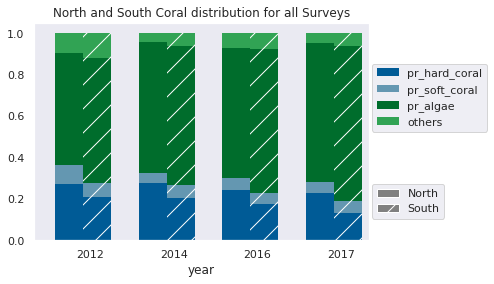

In [42]:
def plot_clustered_stacked(dfall, labels=None, title="North and South Coral distribution for all Surveys",  H="/", **kwargs):
    """Given a list of dataframes, with identical columns and index, create a clustered stacked bar plot. 
labels is a list of the names of the dataframe, used for the legend
title is a string for the title of the plot
H is the hatch used for identification of the different dataframe"""

    n_df = len(dfall)
    n_col = len(dfall[0].columns) 
    n_ind = len(dfall[0].index)
    axe = plt.subplot(111)
    

    for df in dfall : # for each data frame
        axe = df.plot(kind="bar",
                      linewidth=0,
                      stacked=True,
                      ax=axe,
                      legend=False,
                      grid=False,
                      **kwargs,
                     color = ["#005b96","#6497b1","#006D2C", "#31A354"])  # make bar plots

    h,l = axe.get_legend_handles_labels() # get the handles we want to modify
    for i in range(0, n_df * n_col, n_col): # len(h) = n_col * n_df
        for j, pa in enumerate(h[i:i+n_col]):
            for rect in pa.patches: # for each index
                rect.set_x(rect.get_x() + 1 / float(n_df + 1) * i / float(n_col))
                rect.set_hatch(H * int(i / n_col)) #edited part     
                rect.set_width(1 / float(n_df + 1))

    axe.set_xticks((np.arange(0, 2 * n_ind, 2) + 1 / float(n_df + 1)) / 2.)
    axe.set_xticklabels(df.index, rotation = 0)
    axe.set_title(title)

    # Add invisible data to add another legend
    n=[]        
    for i in range(n_df):
        n.append(axe.bar(0, 0, color="gray", hatch=H * i))

    l1 = axe.legend(h[:n_col], l[:n_col], loc=[1.01, 0.5])
    if labels is not None:
        l2 = plt.legend(n, labels, loc=[1.01, 0.1]) 
    axe.add_artist(l1)
    return axe


# Then, just call :
plot_clustered_stacked([Survey_mean_North, Survey_mean_South],["North", "South"]);